In [1]:
import time
import os
import subprocess
import sys
import re
import argparse
import collections
import gzip
import math
import shutil
import matplotlib.pyplot as plt
import wandb
import numpy as np
import time
from datetime import datetime
import random

import seaborn as sns
%matplotlib inline
import logging
from silence_tensorflow import silence_tensorflow
#silence_tensorflow()
os.environ['TPU_LOAD_LIBRARY']='0'
os.environ['TF_ENABLE_EAGER_CLIENT_STREAMING_ENQUEUE']='False'
import tensorflow as tf


import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
from scipy.stats.stats import spearmanr  
## custom modules
import src.aformer_atac as aformer
#import src.aformer_TF as aformer
from src.layers.layers import *
import src.metrics as metrics
from src.optimizers import *
import src.schedulers as schedulers
import src.utils as utils

import training_utils_atac as training_utils


from scipy import stats

2023-03-22 13:34:19.849722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 13:34:20.006835: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 13:34:20.006870: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-22 13:34:20.881205: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='node-2')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE
    options.deterministic=False
    #options.experimental_threading.max_intra_op_parallelism = 1
    mixed_precision.set_global_policy('mixed_bfloat16')
    tf.config.optimizer.set_jit(True)
    #options.num_devices = 64

    BATCH_SIZE_PER_REPLICA = 1
    NUM_REPLICAS = strategy.num_replicas_in_sync
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * NUM_REPLICAS

2023-03-22 13:34:22.530127: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 13:34:22.540554: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 13:34:22.540642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tpu-genformer-v2-6): /proc/driver/nvidia/version does not exist


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


2023-03-22 13:34:22.947061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 13:34:23.460495: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:447] Started server with target: grpc://localhost:47973
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: node-2


INFO:tensorflow:Initializing the TPU system: node-2


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [10]:
#with strategy.scope():

model = aformer.aformer(kernel_transformation='relu_kernel_transformation',
                        dropout_rate=0.05,
                        pointwise_dropout_rate=0.1,
                        input_length=196608,
                        output_length=1536,
                        final_output_length=896,
                        num_heads=8,
                        numerical_stabilizer=0.0000001,
                        nb_random_features=256,
                        max_seq_length=1536,
                        rel_pos_bins=1536,
                        norm=True,
                        BN_momentum=0.90,
                        use_rot_emb = True,
                        use_mask_pos = False,
                        normalize = True,
                        num_transformer_layers=4,
                        inits_type="enformer_performer",
                        load_init=False,
                        stable_variant=False,
                        freeze_conv_layers=False,
                        filter_list_seq=[512,640,768,896,1024,1152],
                        filter_list_atac=[32,64],
                        #global_acc_size=32,
                        learnable_PE=True)


test = tf.ones((1,196608,4)),tf.ones((1,49152,1))#,tf.ones((1,1,1536))
model(test,training=False)
print('ran test input')
model.load_weights("gs://picard-testing-176520/genformer_atac_pretrain/models/aformer_baseline_genformer_atac_196k_glob_acc-False_load-False_frz-False_LR1-0.00025_LR2-0.00025_T-4_D-0.05_2023-03-22_00:30:32/iteration_30/saved_model")
print('loaded weights')


ran test input
loaded weights


In [11]:
def predict_on_batch(model, inputs):
    return model.predict_on_batch(inputs)

@tf.function
def contribution_input_grad(model, model_inputs, gradient_mask):
    seq, atac =model_inputs
    gradient_mask = tf.cast(gradient_mask,dtype=tf.float32)
    gradient_mask_mass = tf.reduce_sum(gradient_mask)

    with tf.GradientTape() as input_grad_tape:
        input_grad_tape.watch(seq)
        input_grad_tape.watch(atac)
        #input_grad_tape.watch(tf_acc)
        inputs = seq,atac#,tf_acc
        prediction, embedding, att_matrices = model.predict_on_batch(inputs)
        
        prediction = tf.cast(prediction,dtype=tf.float32)
        gradient_mask = tf.cast(gradient_mask,dtype=tf.float32)
        prediction_CAGE = tf.reduce_sum(gradient_mask *
                                        prediction) / gradient_mask_mass


    input_grads = input_grad_tape.gradient(prediction_CAGE, inputs)
    
    input_grads_seq = input_grads[0] 
    input_grads_atac = input_grads[1]
    #input_grads_tf_acc = input_grads[2]

    seq_grads = tf.reduce_sum(input_grads_seq[0,:,:] * seq[0,:,:],
                              axis=1)

    atac_grads = input_grads_atac[0,:,] * atac[0,:,]

    #tf_acc_grads = input_grads[2][0,:]

    return seq_grads, atac_grads, prediction, att_matrices, embedding



In [12]:
def one_hot(sequence):
    '''
    convert input string tensor to one hot encoded
    will replace all N character with 0 0 0 0
    '''
    vocabulary = tf.constant(['A', 'C', 'G', 'T'])
    mapping = tf.constant([0, 1, 2, 3])

    init = tf.lookup.KeyValueTensorInitializer(keys=vocabulary,
                                               values=mapping)
    table = tf.lookup.StaticHashTable(init, default_value=0)

    input_characters = tfs.upper(tfs.unicode_split(sequence, 'UTF-8'))

    out = tf.one_hot(table.lookup(input_characters), 
                      depth = 4, 
                      dtype=tf.float32)
    return out


    
def deserialize_val(serialized_example,
                   input_length,
                   max_shift,
                   output_length_ATAC,
                   output_length,
                   crop_size,
                   output_res,
                   atac_mask,
                   use_global_acc,
                   log_atac):
    """Deserialize bytes stored in TFRecordFile."""
    ## parse out feature map
    feature_map = {
        'sequence': tf.io.FixedLenFeature([], tf.string),
        'atac': tf.io.FixedLenFeature([], tf.string),
        'tss_tokens': tf.io.FixedLenFeature([], tf.string),
        'peaks': tf.io.FixedLenFeature([], tf.string),
        'cell_specific_conv_arr': tf.io.FixedLenFeature([], tf.string)
    }
    ### stochastic sequence shift and gaussian noise

    seq_shift=5
    
    input_seq_length = input_length + max_shift
    
    ## now parse out the actual data
    data = tf.io.parse_example(serialized_example, feature_map)
    sequence = one_hot(tf.strings.substr(data['sequence'],
                                 seq_shift,input_length))
    atac = tf.ensure_shape(tf.io.parse_tensor(data['atac'],
                                              out_type=tf.float32),
                           [output_length_ATAC,1])
    peaks = tf.ensure_shape(tf.io.parse_tensor(data['peaks'],
                                              out_type=tf.int32),
                           [output_length])
    peaks_crop = tf.slice(tf.expand_dims(peaks,axis=1),
                     [crop_size,0],
                     [output_length-2*crop_size,-1])
    
    atac_target = atac ## store the target

    masked_atac = atac * atac_mask
    
    if log_atac: 
        masked_atac = tf.math.log1p(masked_atac)
        
    atac_out = tf.reduce_sum(tf.reshape(atac_target, [-1,32]),axis=1,keepdims=True)
    diff = tf.math.sqrt(tf.nn.relu(atac_out - 64.0 * tf.ones(atac_out.shape)))
    atac_out = tf.clip_by_value(atac_out, clip_value_min=0.0, clip_value_max=64.0) + diff
    atac_out = tf.cast(tf.cast(atac_out,dtype=tf.float16),dtype=tf.float32) ### round to be consistent with Enformer
    atac_out = tf.slice(atac_out,
                        [crop_size,0],
                        [output_length-2*crop_size,-1])

    global_acc = tf.ensure_shape(tf.io.parse_tensor(data['cell_specific_conv_arr'],
                                              out_type=tf.float32),
                           [1536])
    global_acc=tf.expand_dims(global_acc,axis=0)
    
    global_acc = tf.math.asinh(global_acc)
    global_acc = (global_acc - tf.math.reduce_mean(global_acc)) / tf.math.reduce_std(global_acc)
    
    if not use_global_acc:
        global_acc = g.normal(global_acc.shape,
                              mean=0.0,
                              stddev=0.001,
                              dtype=tf.float32)
        
    tss_tokens = tf.ensure_shape(tf.io.parse_tensor(data['tss_tokens'],
                                              out_type=tf.int32),
                           [output_length-2*crop_size])
    tss_tokens=tf.expand_dims(tss_tokens,axis=1)
        
        
    return {'sequence': tf.ensure_shape(sequence,
                                        [input_length,4]),
            'atac': tf.ensure_shape(masked_atac,
                                    [output_length_ATAC,1]),
            'tss_tokens': tf.ensure_shape(tss_tokens,
                                      [output_length-crop_size*2,1]),
            'global_acc': tf.ensure_shape(global_acc,
                                          [1,1536]),
            'peaks': tf.ensure_shape(peaks_crop,
                                      [output_length-crop_size*2,1]),
            'target': tf.ensure_shape(atac_out,
                                      [output_length-crop_size*2,1])}

In [18]:
atac_mask = np.ones((1536,1))
for k in tf.range(762,780):
    atac_mask[k,0] = 0.0
atac_mask = tf.constant(atac_mask,dtype=tf.float32)

atac_mask = tf.reshape(tf.tile(atac_mask, [1,32]),[-1])
atac_mask = tf.expand_dims(atac_mask,axis=1)
atac_mask.shape

filename = "gs://picard-testing-176520/genformer_atac_pretrain/196k/genformer_atac_pretrain_globalacc_conv_rpgc_holdout_SINGLE/HG_Jurkat.chr12-9760744-9760917.CD69_promoter.tfr"

g = tf.random.Generator.from_seed(datetime.now().timestamp())
dataset = tf.data.TFRecordDataset(filename,
                                  compression_type='ZLIB',
                                  num_parallel_reads=4)
dataset = dataset.map(lambda record: deserialize_val(record,
                                                     196608,
                                                     10,
                                                         49152,
                                                     1536,
                                                     320,
                                                     128,
                                                     atac_mask,
                                                        True, True),
                      deterministic=False,
                      num_parallel_calls=4)
dataset=dataset.batch(1)
iter_test = iter(dataset)
test = next(iter_test)
inputs = test['sequence'], \
            test['atac']#, \
                #test['global_acc']

mask = np.zeros((1,896,1))
for k in range(896):
    if k in [446,448,450]:
        mask[0,k,0]=1

seq_grads, atac_grads, prediction,att_matrices,embedding = contribution_input_grad(model,inputs, mask)


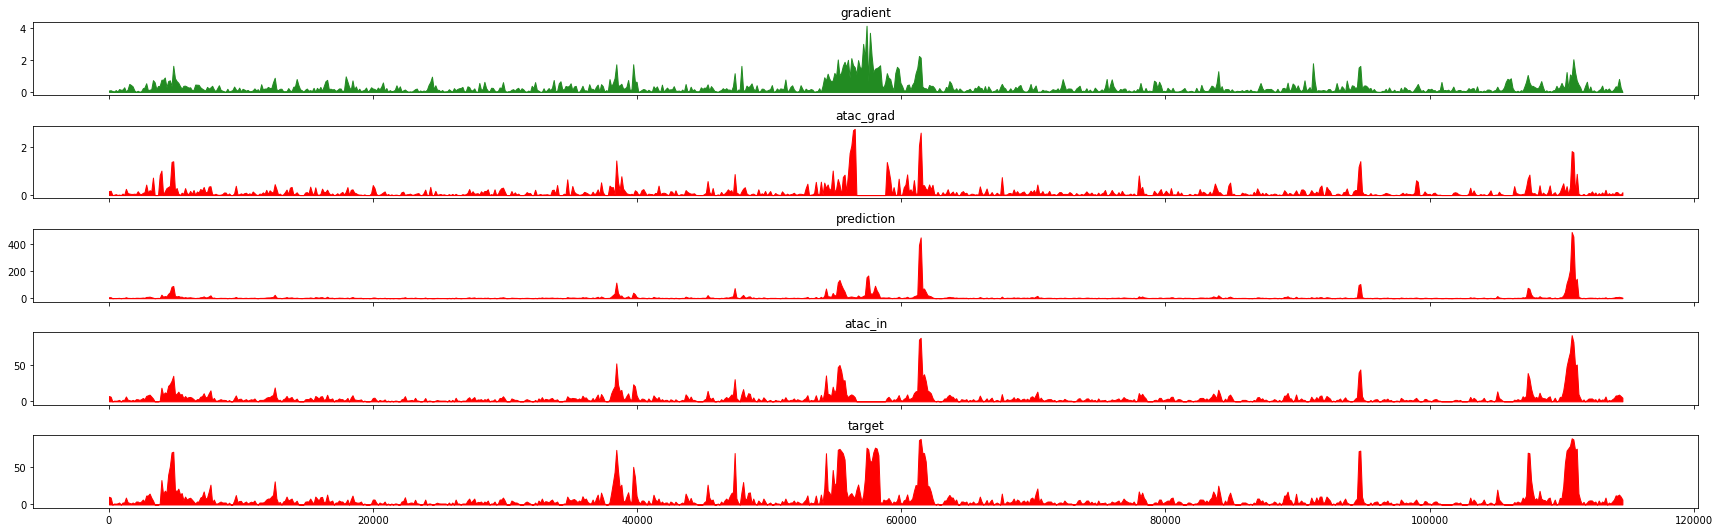

In [19]:

def plot_tracks(tracks, peaks, start,end, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(24, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(start, end, num=len(y[0])), y[0],color=y[1])
    ax.set_title(title)
  #ax.imshow(peaks, aspect = "auto", cmap="viridis")

  plt.tight_layout()


seq_grad = tf.math.abs(tf.reduce_sum(tf.reshape(seq_grads, [1536,128]),axis=1))[320:-320]
atac_grad = tf.math.abs(tf.reduce_sum(tf.reshape(atac_grads,[1536,32]),axis=1))[320:-320]
tracks={'gradient': (np.log(1.0+seq_grad), 'forestgreen'),
        'atac_grad': (np.log(1.0+atac_grad),'red'),
        'prediction': (prediction[0,:,0],'red'),
        'atac_in': (tf.reduce_sum(tf.reshape(test['atac'][0,:,0], [1536,32]),axis=1)[320:-320],'red'),
        'target': (test['target'][0,:,0],'red')}


plot_tracks(tracks, test['peaks'],0,114608)

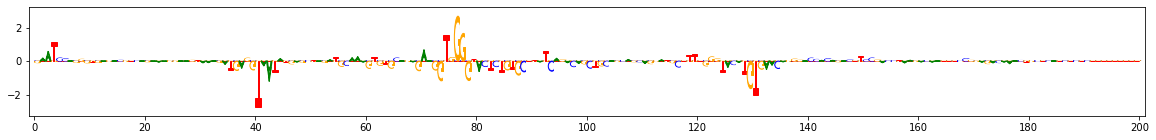

<AxesSubplot:>

In [15]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights((tf.expand_dims(seq_grads,axis=1) * test['sequence'][0,:,:4] * tf.expand_dims(tf.reshape(tf.tile(atac_grads,[1,4]), [-1]), axis=1))[102328:102528,:], 
                          subticks_frequency=20)

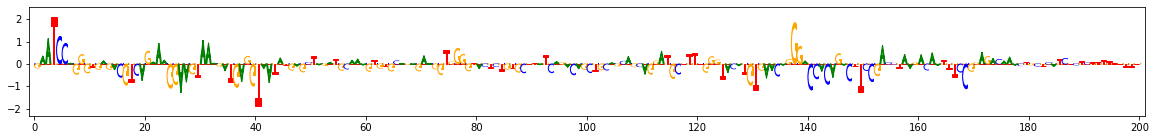

<AxesSubplot:>

In [16]:
##### import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights((tf.expand_dims(seq_grads,axis=1) * test['sequence'][0,:,:4])[102328:102528,:], 
                          subticks_frequency=20)

In [17]:
all_arrs=[]
for idx in range(7):
    k_1,q_1 = att_matrices['layer_' + str(idx)]
    
    for i in range(0,8):
        temp = tf.nn.softmax(tf.matmul(q_1[:,0,i,:],tf.transpose(k_1[:,0,i,:])) / tf.math.sqrt(208.0))
        all_arrs.append(tf.expand_dims(temp,axis=0))
        #window_center = tf.reduce_sum(temp[794:799,:],axis=0)
        #print(window_center.shape)
        #promoter_att_unstim.append(temp)
        #plt.matshow(temp)
        #plt.colorbar()
        #plt.show()
        
    
        
all_arrs_concat = tf.concat(all_arrs, axis=0)
mean_att = tf.reduce_mean(all_arrs_concat,axis=0).numpy()
plt.matshow(mean_att)
plt.colorbar()
plt.show()

att_arr = tf.reduce_sum(mean_att[766:771,:],axis=0).numpy()

tracks={'seq_grad': (seq_grad, 'indianred'),
        'att_score': (att_arr, 'forestgreen'),
        'atac': (tf.reduce_sum(tf.reshape(test['atac'][0,:,:], [1536,32]),axis=1), 'forestgreen')}

def plot_tracks(tracks, peaks, start, end, height=1.5):
  fig, axes = plt.subplots(len(tracks)+1, 1, figsize=(24, height * (len(tracks)+1)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(start, end, num=len(y[0])), y[0],color=y[1])
    ax.set_title(title)
  axes[-1].imshow(peaks, aspect = "auto", cmap="viridis")
  plt.tight_layout()
    
    
#fig,ax = plt.subplots(figsize=(24, 1.5))
peaks = tf.concat([tf.zeros((1,320),dtype=tf.int32), test['peaks'][:,:,0], tf.zeros((1,320),dtype=tf.int32)],axis=1)
peaks_expand=tf.expand_dims(tf.reshape(tf.transpose(tf.tile(peaks,[128,1])),[-1]),axis=0)
#ax.imshow(peaks, aspect = "auto", cmap="viridis")


plot_tracks(tracks,peaks_expand, 0,196608)

KeyError: 'layer_4'

In [191]:
peaks = tf.concat([tf.zeros((1,320),dtype=tf.int32), test['peaks'][:,:,0], tf.zeros((1,320),dtype=tf.int32)],axis=1)
peaks_expand=tf.expand_dims(tf.reshape(tf.transpose(tf.tile(peaks,[128,1])),[-1]),axis=1)

#tf.where(peaks > 0)
tf.where(peaks_expand>0)

<tf.Tensor: shape=(5120, 2), dtype=int64, numpy=
array([[ 45568,      0],
       [ 45569,      0],
       [ 45570,      0],
       ...,
       [152061,      0],
       [152062,      0],
       [152063,      0]])>

In [192]:
tf.reshape(tf.transpose(tf.tile(peaks,[128,1])),[-1]) 

<tf.Tensor: shape=(196608,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>

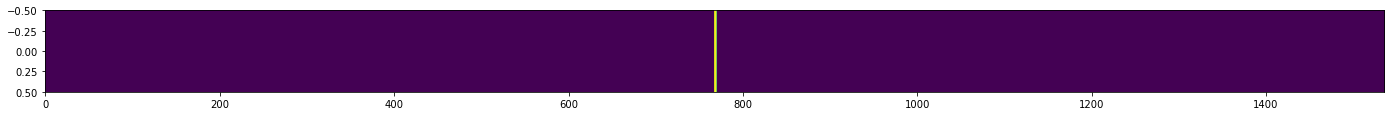

In [193]:
fig,ax = plt.subplots(figsize=(24, 1.5))
peaks = tf.concat([tf.zeros((1,320),dtype=tf.int32), test['tss_tokens'][:,:,0], tf.zeros((1,320),dtype=tf.int32)],axis=1)
ax.imshow(peaks, aspect = "auto", cmap="viridis")

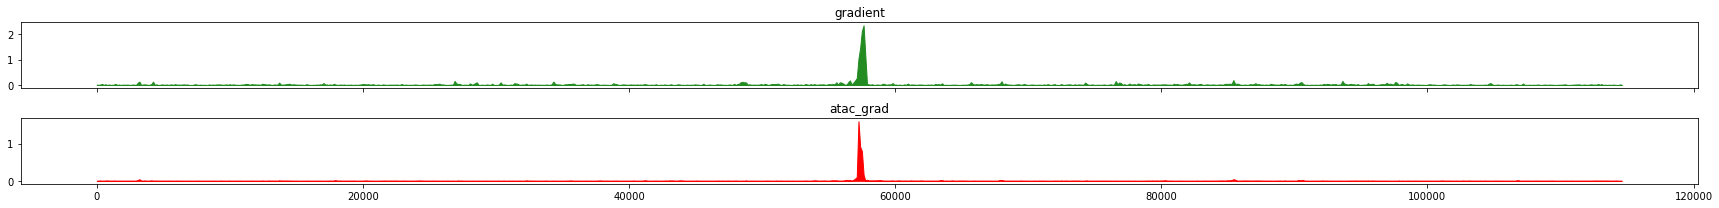

In [24]:

filename = "gs://picard-testing-176520/genformer_atac_pretrain/genformer_atac_pretrain_globalacc_conv_rpgc_holdout_SINGLE/HG_BJ_U_DEEP_SENESCENCE.chr12-9764853-9765078.CD69.tfr"

g = tf.random.Generator.from_seed(datetime.now().timestamp())
dataset = tf.data.TFRecordDataset(filename,
                                  compression_type='ZLIB',
                                  num_parallel_reads=4)
dataset = dataset.map(lambda record: deserialize_val(record,
                                                     196608,
                                                     10,
                                                         49152,
                                                     1536,
                                                     320,
                                                     128,
                                                        False,
                                                        0.15,
                                                        True, True),
                      deterministic=False,
                      num_parallel_calls=4)
dataset=dataset.batch(1)
iter_test = iter(dataset)
test = next(iter_test)
inputs = test['sequence'], \
            test['atac'], \
                test['global_acc']

mask = np.zeros((1,896,1))
for k in range(896):
    if k in [447,448,449]:
        mask[0,k,0]=1

seq_grads, atac_grads, tf_acc_grads, prediction,att_matrices,embedding = contribution_input_grad(model,inputs,mask)



def plot_tracks(tracks, peaks, start,end, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(24, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(start, end, num=len(y[0])), y[0],color=y[1])
    ax.set_title(title)
  #ax.imshow(peaks, aspect = "auto", cmap="viridis")

  plt.tight_layout()


seq_grad = tf.math.abs(tf.reduce_sum(tf.reshape(seq_grads, [1536,128]),axis=1))[320:-320]
atac_grad = tf.math.abs(tf.reduce_sum(tf.reshape(atac_grads,[1536,32]),axis=1))[320:-320]
tracks={'gradient': (np.log(1.0+seq_grad), 'forestgreen'),
        'atac_grad': (np.log(1.0+atac_grad),'red')}


plot_tracks(tracks, test['peaks'],0,114608)

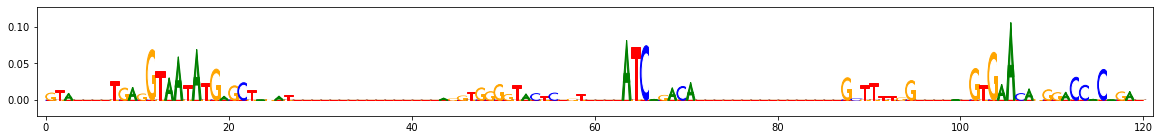

<AxesSubplot:>

In [25]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(np.abs((tf.expand_dims(seq_grads,axis=1) * test['sequence'][0,:,:4] * tf.expand_dims(tf.reshape(tf.tile(atac_grads,[1,4]), [-1]), axis=1)))[98221:98341,:], 
                          subticks_frequency=20)

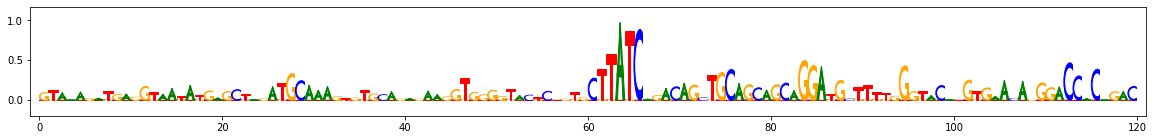

<AxesSubplot:>

In [26]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(np.abs((tf.expand_dims(seq_grads,axis=1) * test['sequence'][0,:,:4]))[98221:98341,:], 
                          subticks_frequency=20)

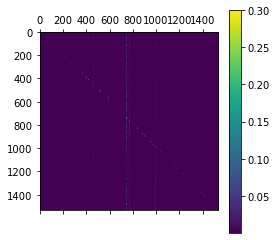

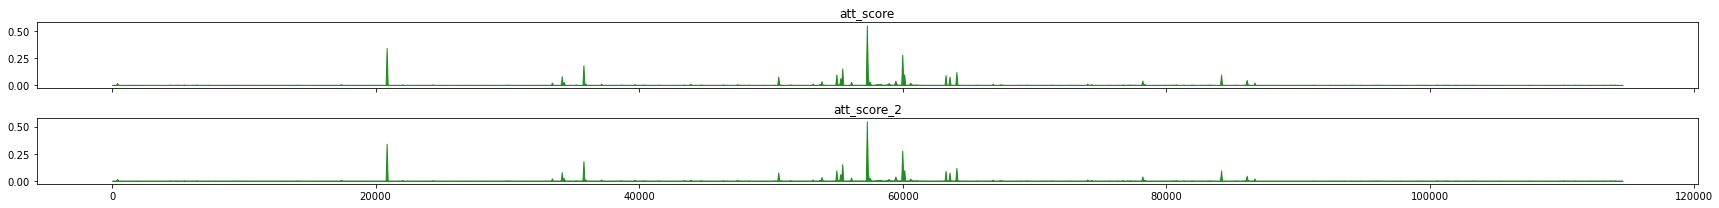

In [57]:
len(tracks)

1

In [26]:
checkpoint_path="gs://picard-testing-176520/genformer_atac_pretrain_globalacc_conv_rpgc/models/aformer_baseline_genformer_atac_196k_glob_acc-True_load-True_frz-False_LR1-5e-06_LR2-0.0001_T-7_D-0.05_2023-03-15_03:26:43/iteration_58"
inside_checkpoint=tf.train.list_variables(tf.train.latest_checkpoint(checkpoint_path))
reader = tf.train.load_checkpoint(checkpoint_path)
inside_checkpoint

<tf.Tensor: shape=(25, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)>

In [61]:
    vocabulary = tf.constant(['A', 'C', 'G', 'T'])
    mapping = tf.constant([0, 1, 2, 3])
    
9764948 - (9666662 + 5)

98281